In [ ]:
import json
from PIL import Image
import os
from torchvision import transforms, models
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn as nn
import torch.optim as optim
import torch
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from torch.optim.lr_scheduler import ReduceLROnPlateau

class FashionDataset(Dataset):
    def __init__(self, dataset, transform=None):
        self.images = [data['image'] for data in dataset]
        self.labels = [data['label'] for data in dataset]
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

def create_resnet18_model(num_classes):
    model = models.resnet18(pretrained=True)
    for param in model.parameters():
        param.requires_grad = True
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, num_classes)
    return model

def train_model(model, train_loader, val_loader, criterion, optimizer, device, scheduler=None, num_epochs=50, patience=5):
    best_model_wts = model.state_dict()
    best_acc = 0.0
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    early_stopping_counter = 0
    best_val_loss = float('inf')

    for epoch in range(num_epochs):
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
                data_loader = train_loader
            else:
                model.eval()
                data_loader = val_loader

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in data_loader:
                inputs = inputs.to(device)
                labels = labels.to(device)
                optimizer.zero_grad()
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(data_loader.dataset)
            epoch_acc = running_corrects.double() / len(data_loader.dataset)
            if phase == 'train':
                train_losses.append(epoch_loss)
                train_accuracies.append(epoch_acc.item())
            else:
                val_losses.append(epoch_loss)
                val_accuracies.append(epoch_acc.item())
                if scheduler is not None:
                    scheduler.step(epoch_loss)
                if epoch_loss < best_val_loss:
                    best_val_loss = epoch_loss
                    early_stopping_counter = 0
                    best_model_wts = model.state_dict()
                else:
                    early_stopping_counter += 1
                    if early_stopping_counter >= patience:
                        model.load_state_dict(best_model_wts)
                        plot_training_curves(train_losses, val_losses, train_accuracies, val_accuracies)
                        return model

    model.load_state_dict(best_model_wts)
    plot_training_curves(train_losses, val_losses, train_accuracies, val_accuracies)
    return model

def plot_training_curves(train_losses, val_losses, train_accuracies, val_accuracies):
    epochs = range(1, len(train_losses) + 1)
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, 'bo-', label='Training Loss')
    plt.plot(epochs, val_losses, 'ro-', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, 'bo-', label='Training Accuracy')
    plt.plot(epochs, val_accuracies, 'ro-', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.tight_layout()
    plt.show()

def test_model(model, test_loader, device):
    model.eval()
    running_corrects = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            running_corrects += torch.sum(preds == labels.data)
    total = len(test_loader.dataset)
    acc = running_corrects.double() / total
    print(f'Test Accuracy: {acc:.4f}')

def evaluate_model(model, test_loader, device, class_names):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    print("Classification Report:")
    print(classification_report(all_labels, all_preds, target_names=class_names))
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)
    thresh = cm.max() / 2.
    for i in range(len(class_names)):
        for j in range(len(class_names)):
            plt.text(j, i, format(cm[i, j], 'd'), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()

def predict(model, image_path, device, data_transforms, class_names):
    model.eval()
    image = Image.open(image_path).convert('RGB')
    image = data_transforms(image).unsqueeze(0)
    image = image.to(device)
    with torch.no_grad():
        outputs = model(image)
        _, preds = torch.max(outputs, 1)
    predicted_class = class_names[preds.item()]
    return predicted_class

def main():
    with open('./【AiDLab】A100/LAT/label/LAT.json', 'r') as f:
        data = json.load(f)
    all_items = []
    for entry in data:
        all_items.extend(entry['question'])
        all_items.extend(entry['answers'])
    items = []
    for item in all_items:
        category, id_ = item.split('_')
        items.append({'category': category, 'id': id_})
    unique_items = { (item['category'], item['id']) for item in items }
    unique_items = [ {'category': cat, 'id': id_} for cat, id_ in unique_items ]
    category_mapping = {
        'Shoes': 'shoes',
        'Top': 'clothing',
        'Pants': 'clothing',
        'Skirt': 'clothing',
        'Dress': 'clothing',
        'Outwear': 'clothing',
        'Earing': 'accessories',
        'Bracelet': 'accessories',
        'Watches': 'accessories',
        'Hat': 'accessories',
        'Neckline': 'accessories',
        'Sunglasses': 'accessories',
        'Bags': 'bags'
    }
    data_dir = './【AiDLab】A100/LAT/image'
    dataset = []
    for item in unique_items:
        category = item['category']
        id_ = item['id']
        label = category_mapping.get(category)
        if label is None:
            continue
        image_path = os.path.join(data_dir, f"{id_}.jpg")
        if not os.path.exists(image_path):
            continue
        image = Image.open(image_path).convert('RGB')
        dataset.append({'image': image, 'label': label})
    labels = [data['label'] for data in dataset]
    label_encoder = LabelEncoder()
    encoded_labels = label_encoder.fit_transform(labels)
    for idx, data_item in enumerate(dataset):
        data_item['label'] = encoded_labels[idx]
    class_names = label_encoder.classes_
    data_transforms = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    full_dataset = FashionDataset(dataset, transform=data_transforms)
    train_size = int(0.6 * len(full_dataset))
    val_size = int(0.2 * len(full_dataset))
    test_size = len(full_dataset) - train_size - val_size
    train_dataset, val_dataset, test_dataset = random_split(full_dataset, [train_size, val_size, test_size])
    batch_size = 8
    num_workers = 0
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
    num_classes = len(class_names)
    model = create_resnet18_model(num_classes=num_classes)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-5)
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, verbose=True)
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model = train_model(model, train_loader, val_loader, criterion, optimizer, device, scheduler=scheduler, num_epochs=50, patience=5)
    test_model(model, test_loader, device)
    evaluate_model(model, test_loader, device, class_names)
    while True:
        image_path = input("Enter the image path for prediction ('exit' to quit):")
        if image_path.lower() == 'exit':
            break
        if not os.path.exists(image_path):
            continue
        predicted_class = predict(model, image_path, device, data_transforms, class_names)
        print(f"Predicted Class: {predicted_class}")

if __name__ == '__main__':
    main()


In [3]:
# 导入必要的库
import json
from PIL import Image
import os
from torchvision import transforms, models
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn as nn
import torch.optim as optim
import torch
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from torch.optim.lr_scheduler import ReduceLROnPlateau

# 让 matplotlib 的图像嵌入在 Notebook 中
%matplotlib inline


In [5]:
# 自定义数据集类
class FashionDataset(Dataset):
    def __init__(self, dataset, transform=None):
        self.images = [data['image'] for data in dataset]
        self.labels = [data['label'] for data in dataset]
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label


In [7]:
# 定义模型（使用预训练的 ResNet18）
def create_resnet18_model(num_classes):
    model = models.resnet18(pretrained=True)
    # 解冻所有参数
    for param in model.parameters():
        param.requires_grad = True
    # 修改最后的全连接层
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, num_classes)
    return model


In [9]:
# 训练模型函数（添加早停法）
def train_model(model, train_loader, val_loader, criterion, optimizer, device, scheduler=None, num_epochs=50, patience=5):
    best_model_wts = model.state_dict()
    best_acc = 0.0

    # 用于记录训练和验证的损失和准确率
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    # 早停参数
    early_stopping_counter = 0
    best_val_loss = float('inf')

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        # 每个 epoch 有两个阶段：训练和验证
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # 设置模型为训练模式
                data_loader = train_loader
            else:
                model.eval()   # 设置模型为评估模式
                data_loader = val_loader

            running_loss = 0.0
            running_corrects = 0

            # 遍历数据
            for inputs, labels in data_loader:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                # 前向传播
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # 训练阶段反向传播和优化
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # 统计损失和准确率
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            # 计算 epoch 的损失和准确率
            epoch_loss = running_loss / len(data_loader.dataset)
            epoch_acc = running_corrects.double() / len(data_loader.dataset)

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # 记录损失和准确率
            if phase == 'train':
                train_losses.append(epoch_loss)
                train_accuracies.append(epoch_acc.item())
            else:
                val_losses.append(epoch_loss)
                val_accuracies.append(epoch_acc.item())

                # 在验证阶段，更新学习率调度器
                if scheduler is not None:
                    scheduler.step(epoch_loss)

                # 早停机制
                if epoch_loss < best_val_loss:
                    best_val_loss = epoch_loss
                    early_stopping_counter = 0
                    best_model_wts = model.state_dict()
                else:
                    early_stopping_counter += 1
                    if early_stopping_counter >= patience:
                        print(f'早停触发，提前停止训练。')
                        # 加载最佳模型权重
                        model.load_state_dict(best_model_wts)
                        # 绘制损失和准确率的折线图
                        plot_training_curves(train_losses, val_losses, train_accuracies, val_accuracies)
                        return model

        print()  # 换行

    print(f'Best val Acc: {max(val_accuracies):.4f}')
    # 加载最佳模型权重
    model.load_state_dict(best_model_wts)

    # 绘制损失和准确率的折线图
    plot_training_curves(train_losses, val_losses, train_accuracies, val_accuracies)

    return model


In [11]:
# 绘制训练曲线的函数
def plot_training_curves(train_losses, val_losses, train_accuracies, val_accuracies):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(12, 5))

    # 绘制损失曲线
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, 'bo-', label='训练损失')
    plt.plot(epochs, val_losses, 'ro-', label='验证损失')
    plt.title('训练和验证损失')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # 绘制准确率曲线
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, 'bo-', label='训练准确率')
    plt.plot(epochs, val_accuracies, 'ro-', label='验证准确率')
    plt.title('训练和验证准确率')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()


In [13]:
# 测试模型函数
def test_model(model, test_loader, device):
    model.eval()
    running_corrects = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            running_corrects += torch.sum(preds == labels.data)

    total = len(test_loader.dataset)
    acc = running_corrects.double() / total
    print(f'Test Accuracy: {acc:.4f}')


In [15]:
# 评估模型函数（在混淆矩阵中添加数字）
def evaluate_model(model, test_loader, device, class_names):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    print("分类报告：")
    print(classification_report(all_labels, all_preds, target_names=class_names))

    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('混淆矩阵')
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)

    # 在混淆矩阵中添加数字
    thresh = cm.max() / 2.
    for i in range(len(class_names)):
        for j in range(len(class_names)):
            plt.text(j, i, format(cm[i, j], 'd'),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('真实标签')
    plt.xlabel('预测标签')
    plt.tight_layout()
    plt.show()


In [17]:
# 预测函数
def predict(model, image_path, device, data_transforms, class_names):
    model.eval()
    image = Image.open(image_path).convert('RGB')
    image = data_transforms(image).unsqueeze(0)  # 增加 batch 维度
    image = image.to(device)

    with torch.no_grad():
        outputs = model(image)
        _, preds = torch.max(outputs, 1)
    predicted_class = class_names[preds.item()]
    return predicted_class


In [19]:
# 加载 JSON 文件
with open('./【AiDLab】A100/LAT/label/LAT.json', 'r') as f:
    data = json.load(f)

all_items = []

for entry in data:
    all_items.extend(entry['question'])
    all_items.extend(entry['answers'])

items = []
for item in all_items:
    category, id_ = item.split('_')
    items.append({'category': category, 'id': id_})

unique_items = { (item['category'], item['id']) for item in items }
unique_items = [ {'category': cat, 'id': id_} for cat, id_ in unique_items ]

category_mapping = {
    'Shoes': 'shoes',
    'Top': 'clothing',
    'Pants': 'clothing',
    'Skirt': 'clothing',
    'Dress': 'clothing',
    'Outwear': 'clothing',
    'Earing': 'accessories',
    'Bracelet': 'accessories',
    'Watches': 'accessories',
    'Hat': 'accessories',
    'Neckline': 'accessories',
    'Sunglasses': 'accessories',
    'Bags': 'bags'
}

data_dir = './【AiDLab】A100/LAT/image'  # 确保路径正确
dataset = []

for item in unique_items:
    category = item['category']
    id_ = item['id']
    label = category_mapping.get(category)
    if label is None:
        continue

    image_path = os.path.join(data_dir, f"{id_}.jpg")
    if not os.path.exists(image_path):
        print(f"图像文件不存在：{image_path}")
        continue

    image = Image.open(image_path).convert('RGB')
    dataset.append({'image': image, 'label': label})

labels = [data['label'] for data in dataset]
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)

for idx, data_item in enumerate(dataset):
    data_item['label'] = encoded_labels[idx]

class_names = label_encoder.classes_
print("类别名称和对应的编码：")
for idx, class_name in enumerate(class_names):
    print(f"{idx}: {class_name}")


类别名称和对应的编码：
0: accessories
1: bags
2: clothing
3: shoes


In [20]:
# 定义数据转换（添加数据增强）
data_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

# 创建数据集实例
full_dataset = FashionDataset(dataset, transform=data_transforms)

train_size = int(0.6 * len(full_dataset))
val_size = int(0.2 * len(full_dataset))
test_size = len(full_dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(full_dataset, [train_size, val_size, test_size])


In [21]:
batch_size = 8  # 调整 batch size
num_workers = 0  # 或者根据您的系统配置调整

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)


In [22]:
num_classes = len(class_names)
model = create_resnet18_model(num_classes=num_classes)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-5)  # 更新优化器，包含所有参数

# 定义学习率调度器
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, verbose=True)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)


/opt/anaconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/opt/anaconda3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Epoch 1/50
----------
train Loss: 1.2868 Acc: 0.3946
val Loss: 0.9879 Acc: 0.6103

Epoch 2/50
----------
train Loss: 0.8066 Acc: 0.7966
val Loss: 0.6535 Acc: 0.8235

Epoch 3/50
----------
train Loss: 0.6202 Acc: 0.8260
val Loss: 0.4476 Acc: 0.8971

Epoch 4/50
----------
train Loss: 0.5041 Acc: 0.8824
val Loss: 0.3549 Acc: 0.9338

Epoch 5/50
----------
train Loss: 0.4351 Acc: 0.8946
val Loss: 0.3020 Acc: 0.9338

Epoch 6/50
----------
train Loss: 0.3559 Acc: 0.9020
val Loss: 0.2504 Acc: 0.9338

Epoch 7/50
----------
train Loss: 0.2779 Acc: 0.9314
val Loss: 0.2202 Acc: 0.9338

Epoch 8/50
----------
train Loss: 0.2763 Acc: 0.9265
val Loss: 0.2297 Acc: 0.9265

Epoch 9/50
----------
train Loss: 0.2529 Acc: 0.9436
val Loss: 0.1571 Acc: 0.9632

Epoch 10/50
----------
train Loss: 0.1726 Acc: 0.9706
val Loss: 0.1617 Acc: 0.9632

Epoch 11/50
----------
train Loss: 0.1933 Acc: 0.9730
val Loss: 0.1564 Acc: 0.9412

Epoch 12/50
----------
train Loss: 0.1852 Acc: 0.9608
val Loss: 0.1290 Acc: 0.9706

E

/var/folders/87/xplw0rd92vxb56h8bts0kjkr0000gn/T/ipykernel_83760/616528480.py:25: UserWarning: Glyph 35757 (\N{CJK UNIFIED IDEOGRAPH-8BAD}) missing from current font.
  plt.tight_layout()
/var/folders/87/xplw0rd92vxb56h8bts0kjkr0000gn/T/ipykernel_83760/616528480.py:25: UserWarning: Glyph 32451 (\N{CJK UNIFIED IDEOGRAPH-7EC3}) missing from current font.
  plt.tight_layout()
/var/folders/87/xplw0rd92vxb56h8bts0kjkr0000gn/T/ipykernel_83760/616528480.py:25: UserWarning: Glyph 21644 (\N{CJK UNIFIED IDEOGRAPH-548C}) missing from current font.
  plt.tight_layout()
/var/folders/87/xplw0rd92vxb56h8bts0kjkr0000gn/T/ipykernel_83760/616528480.py:25: UserWarning: Glyph 39564 (\N{CJK UNIFIED IDEOGRAPH-9A8C}) missing from current font.
  plt.tight_layout()
/var/folders/87/xplw0rd92vxb56h8bts0kjkr0000gn/T/ipykernel_83760/616528480.py:25: UserWarning: Glyph 35777 (\N{CJK UNIFIED IDEOGRAPH-8BC1}) missing from current font.
  plt.tight_layout()
/var/folders/87/xplw0rd92vxb56h8bts0kjkr0000gn/T/ipykernel_8

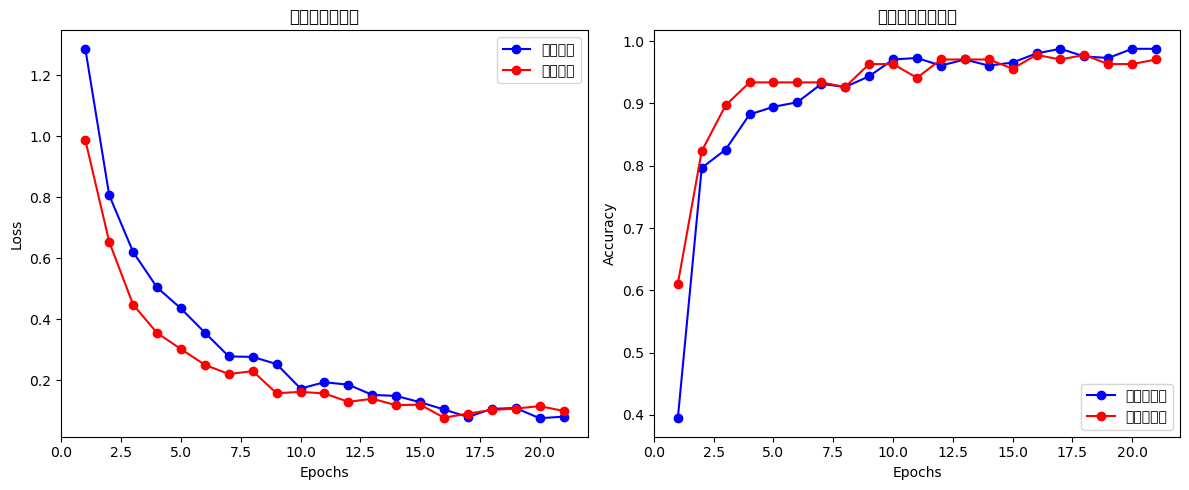

In [23]:
# 训练模型并打印每个 epoch 的训练准确率
model = train_model(model, train_loader, val_loader, criterion, optimizer, device,
                    scheduler=scheduler, num_epochs=50, patience=5)


Test Accuracy: 0.9191
分类报告：
              precision    recall  f1-score   support

 accessories       0.74      0.93      0.82        15
        bags       0.95      0.72      0.82        25
    clothing       1.00      1.00      1.00        70
       shoes       0.93      1.00      0.96        26

    accuracy                           0.94       136
   macro avg       0.90      0.91      0.90       136
weighted avg       0.95      0.94      0.94       136



/var/folders/87/xplw0rd92vxb56h8bts0kjkr0000gn/T/ipykernel_83760/2408152871.py:38: UserWarning: Glyph 39044 (\N{CJK UNIFIED IDEOGRAPH-9884}) missing from current font.
  plt.tight_layout()
/var/folders/87/xplw0rd92vxb56h8bts0kjkr0000gn/T/ipykernel_83760/2408152871.py:38: UserWarning: Glyph 27979 (\N{CJK UNIFIED IDEOGRAPH-6D4B}) missing from current font.
  plt.tight_layout()
/var/folders/87/xplw0rd92vxb56h8bts0kjkr0000gn/T/ipykernel_83760/2408152871.py:38: UserWarning: Glyph 26631 (\N{CJK UNIFIED IDEOGRAPH-6807}) missing from current font.
  plt.tight_layout()
/var/folders/87/xplw0rd92vxb56h8bts0kjkr0000gn/T/ipykernel_83760/2408152871.py:38: UserWarning: Glyph 31614 (\N{CJK UNIFIED IDEOGRAPH-7B7E}) missing from current font.
  plt.tight_layout()
/var/folders/87/xplw0rd92vxb56h8bts0kjkr0000gn/T/ipykernel_83760/2408152871.py:38: UserWarning: Glyph 30495 (\N{CJK UNIFIED IDEOGRAPH-771F}) missing from current font.
  plt.tight_layout()
/var/folders/87/xplw0rd92vxb56h8bts0kjkr0000gn/T/ipyker

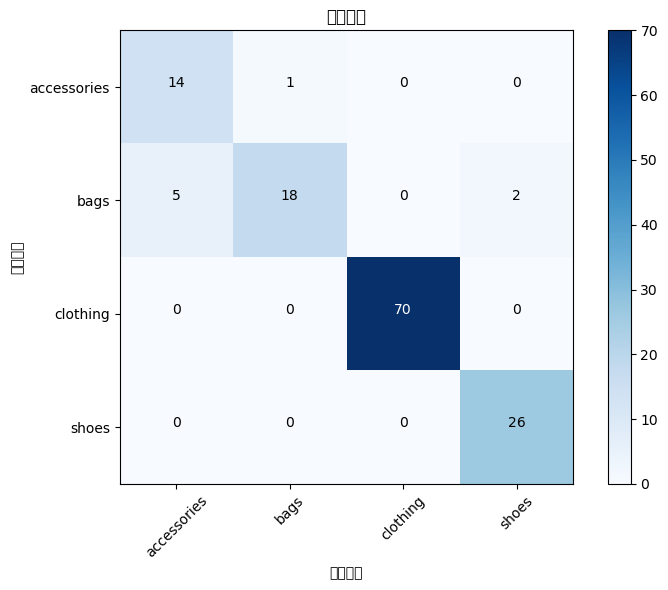

In [24]:
# 测试模型
test_model(model, test_loader, device)
# 评估模型
evaluate_model(model, test_loader, device, class_names)


In [ ]:
# 问答环节：允许用户输入图像路径，模型进行预测
while True:
    image_path = input("请输入要预测的图像路径（输入 'exit' 退出）：")
    if image_path.lower() == 'exit':
        break
    if not os.path.exists(image_path):
        print("图像文件不存在，请重新输入。")
        continue
    predicted_class = predict(model, image_path, device, data_transforms, class_names)
    print(f"预测类别：{predicted_class}")
